<a href="https://colab.research.google.com/github/djiang05/grade_prediction/blob/main/320_HW3_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sklearn.model_selection as skm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Torch packages
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset

from scipy.optimize import linear_sum_assignment

In [ ]:
# df load and shape cleaning

# Load csv
df = pd.read_csv('/content/drive/MyDrive/Class Notes/CMSC320/HW3/merged.csv')
# Rename cols
df.columns = ['Unnamed: 0', 'Timestamp',
              'attendance', # 'I come to lecture:'
              'prior_exp', # 'I've had prior machine learning / data science experience'
              'afternoon_section', # 'Which section are you in?'
              'study_len', # 'About how long, in hours, did you study for exam 1?'
              'year', # 'What year are you?'
              'readings', # 'Did you do the readings?'
              'scrolling_len', # How many hours a day on average do you spend on sites with infinite scroll?
              'sleep_len', # How many hours of sleep did you get the night before the exam?
              'left_early', # Did you leave the exam early?
              'thought_grade', # What grade do you think you got?
              'garbage', # "I wanted the extra credit but just put down random responses (you'll still get the extra credit if you say yes)",
              'Total Score', 'Max Points']

# for col in df.columns:
#   print(col, df[col].isna().sum())

# Clean out garbage responses
df = df[df['garbage'] == 'No']
# Drop irrelevant cols
df.drop(columns=['Unnamed: 0', 'Timestamp', 'garbage', 'Max Points'], inplace=True)



# Fixing what I think is improper coding because this question was required
    # df['prior_exp'].isna().sum() #= 72
    # df['afternoon_section'].isna().sum() #= 31
df['prior_exp'] = df['prior_exp'].apply(lambda x: x if type(x) == str else "None")
# Reset indices
df.reset_index(drop=True, inplace=True)

# Translating all to numerics
df['attendance'] = df['attendance'].map({'Always': 3, 'More than half the time': 2, 'Less than half the time': 1, 'Basically never': 0})
df['prior_exp'] = df['prior_exp'].map({'Quite a bit': 2, 'Some': 1, 'None': 0})
df['afternoon_section'] = df['afternoon_section'].map({'2:00pm': 1, '9:30am': 0})
df['year'] = df['year'].map({'Junior': 3, 'Sophomore': 2, 'Senior': 4, "It's complicated": -1})
df['readings'] = df['readings'].map({'Some of them': 1, 'All of them': 2, 'None of them': 0, "I don't want to respond": -1})
df['left_early'] = df['left_early'].map({'Yes': 1, 'No': 0})
df['thought_grade'] = df['thought_grade'].map({'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0, 'Prefer not to say': -1})

# Nearest Neighbor impute NAs in afternoon_section
imputer = KNNImputer(n_neighbors=5, weights='distance')
df['afternoon_section'] = imputer.fit_transform(df[['afternoon_section']])
# df['afternoon_section'] = df['afternoon_section'].apply(lambda x: 1 if x >= 0.5 else 0)

# for col in df.columns:
#   print(col, df[col].isna().sum())

df.head()

,attendance,prior_exp,afternoon_section,study_len,year,readings,scrolling_len,sleep_len,left_early,thought_grade,Total Score
0,3,0,0.616438,9.0,3,1,6.0,7.0,1,1,42.3
1,3,0,0.616438,5.0,3,1,2.0,7.0,0,3,51.5
2,3,0,0.616438,6.0,3,2,0.0,8.0,0,3,52.4
3,3,2,0.616438,3.0,3,1,3.0,3.0,0,2,49.5
4,3,0,0.616438,5.0,3,1,5.0,7.0,0,2,42.3


In [ ]:
# for col in df.columns:
#   print(col, df[col].unique())

# attendance ['Always' 'Less than half the time' 'More than half the time'
#  'Basically never']
# prior_exp [nan 'Quite a bit' 'Some']
# section [nan '2:00pm' '9:30am']
# study_len [ 9.   5.   6.   3.   8.  20.   4.  16.  40.  30.  12.   1.  10.   7.
#  18.  11.  24.  13.   2.  15.  22.  48.   6.7 14.   2.5 47. ]
# year ['Junior' 'Sophomore' 'Senior' "It's complicated"]
# readings ['Some of them' 'All of them' 'None of them' "I don't want to respond"]
# scrolling_len [ 6.    2.    0.    3.    5.    4.    1.    1.5   2.5   7.    0.5   3.5
#  11.    8.    1.75  0.25]
# sleep_len [ 7.   8.   3.   9.   6.   5.   4.   7.5 10.   6.5  2.   1.   3.5  5.5
#   4.3  1.5  0. ]
# left_early ['Yes' 'No']
# thought_grade ['D' 'B' 'C' 'A' 'F' 'Prefer not to say']
# garbage ['No']
# Total Score [42.3 51.5 52.4 49.5 57.1 58.9 48.8 54.4 32.3 38.9 35.7 57.4 31.3 47.5
#  33.  41.4 52.3 53.4 45.8 57.5 46.2 36.4 34.8 39.  41.3 44.9 50.5 49.9
#  30.2 42.4 61.5 35.1 48.3 53.5 55.9 30.3 40.3 39.9 43.  39.3 53.9 48.4
#  48.5 43.8 37.9 55.5 21.4 42.2 38.4 57.3 38.5 45.9 38.  33.8 52.9 30.4
#  51.9 55.  53.6 39.4 27.5 50.4 35.8 30.9 27.9 48.6 63.9 33.5 44.4 53.3
#  23.5 49.  43.4 46.4 50.  57.9 35.5 23.3 55.4 33.9  4.7 47.  45.  26.5
#  28.8 42.9 44.5 37.8 51.  35.9 44.1 34.4 40.9 51.8 32.8 55.6 49.8 37.4
#  41.8 43.9 43.3 29.4 27.3 42.8 40.  28.9 10.3 59.5 32.5 45.4 58.1 21.9
#  28.4 54.3 41.  34.3 22.8 18.  33.1 41.7 39.5 50.3 51.4]

In [ ]:
df.head()
# df.drop(columns=['Total Score'])

,attendance,prior_exp,afternoon_section,study_len,year,readings,scrolling_len,sleep_len,left_early,thought_grade,Total Score
0,3,0,0.616438,9.0,3,1,6.0,7.0,1,1,42.3
1,3,0,0.616438,5.0,3,1,2.0,7.0,0,3,51.5
2,3,0,0.616438,6.0,3,2,0.0,8.0,0,3,52.4
3,3,2,0.616438,3.0,3,1,3.0,3.0,0,2,49.5
4,3,0,0.616438,5.0,3,1,5.0,7.0,0,2,42.3


In [ ]:
# PCA
pca = PCA(svd_solver = 'auto')
scaler = StandardScaler()

pca.fit(scaler.fit_transform(df.drop(columns=['Total Score'])))
var_explained = np.cumsum(pca.explained_variance_ratio_)

pca_dim = np.argmax(var_explained > 0.90) + 1
print(f"Number of dimensions to explain 90% variance: {pca_dim}")

df_pca = pca.fit_transform(scaler.fit_transform(df.drop(columns=['Total Score'])))
# Only keep most important PCs
df_pca = pd.DataFrame(
    df_pca,
    columns=[f'PC{i+1}' for i in range(df_pca.shape[1])]
)
df_pca.index = df.index

df_pca = pd.concat([df_pca.loc[:, 'PC1':'PC9'], df['Total Score']], axis=1)
df_pca.head()

Number of dimensions to explain 90% variance: 9


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Total Score
0,-1.093273,0.776946,-1.139158,1.053088,-0.664098,1.677807,1.600344,0.495584,-0.848380,42.3
1,0.765144,0.395351,-0.360953,0.984248,-0.820124,-0.195821,-0.586329,0.185924,0.240267,51.5
2,2.030015,0.289363,-0.459133,0.175105,-0.260565,-0.993501,-0.311836,0.769829,-0.325991,52.4
3,-0.601173,-0.688920,1.791093,0.175052,-0.573859,-0.213732,-0.102089,-1.814207,-0.564636,49.5
4,-0.150242,0.060673,-0.602866,1.050864,-1.100503,1.183514,-0.194584,-0.020829,-0.395001,42.3


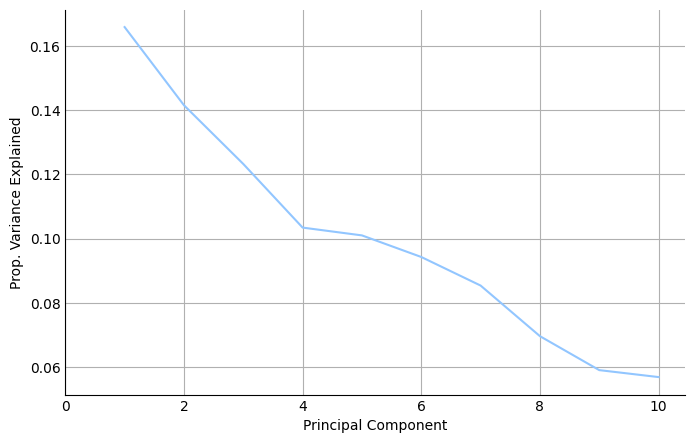

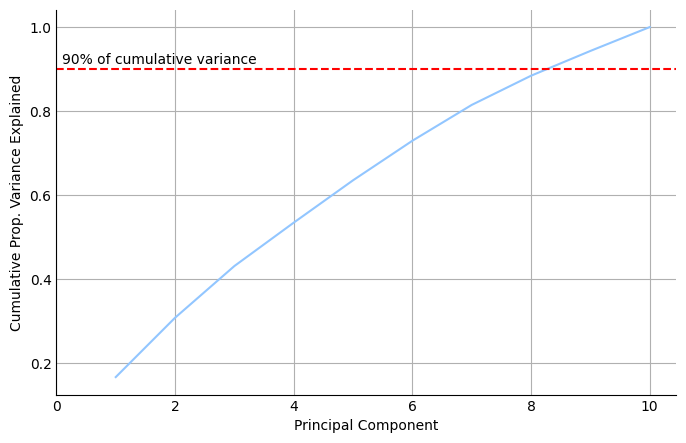

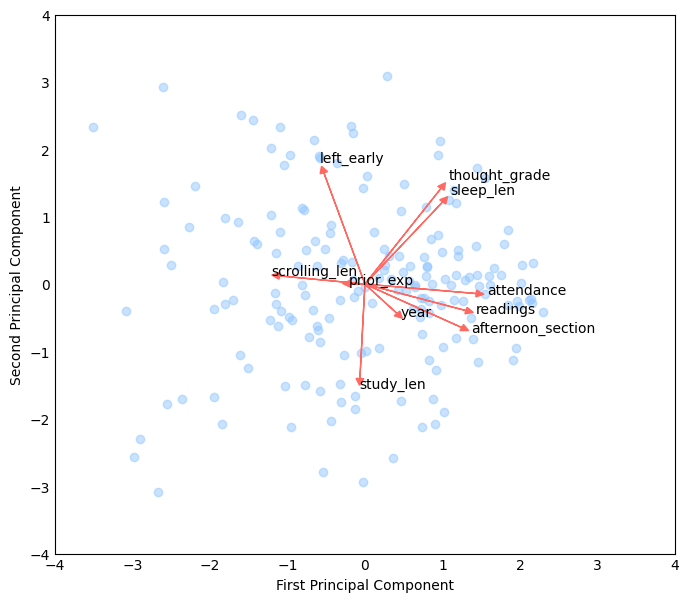

In [ ]:
# Scree plots and plotting of observations in latent space
plt.style.use("seaborn-v0_8-pastel")

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)

plt.xticks(np.arange(0, 11, 2))
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Principal Component')
plt.ylabel('Prop. Variance Explained')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 11), var_explained)

plt.xticks(np.arange(0, 11, 2))
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% of cumulative variance')
plt.text(
    x=0.1, y=0.9 + 0.005,                 # small vertical offset
    s='90% of cumulative variance',
    color='black',
    ha='left', va='bottom'
)

plt.xlabel('Principal Component')
plt.ylabel('Cumulative Prop. Variance Explained')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 7))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], alpha=0.5)

plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

loadings = pca.components_

for i in range(10):
    plt.arrow(0, 0, loadings[0, i] * 3, loadings[1, i] * 3, color = '#FF6961', head_width=0.1, head_length=0.1, alpha=1)
    plt.text(loadings[0, i] * 3.3, loadings[1, i] * 3.3, df.columns[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()


In [ ]:
# Part 1: predict either passing or failing
def bin_pass_fail(df):
  df1 = df.copy(deep=True)
  df1['passed'] = df['Total Score'].apply(lambda x: 1 if x >= 65*0.7 else 0)
  df1.drop(['Total Score'], inplace=True, axis=1)

  return df1

df1 = bin_pass_fail(df)
df1_pca = bin_pass_fail(df_pca)

kfold = skm.KFold(10, random_state=0, shuffle=True)
# Note that we have 104 fails and 73 passes: 58% failure rate

Without PCA:
Best k: 13


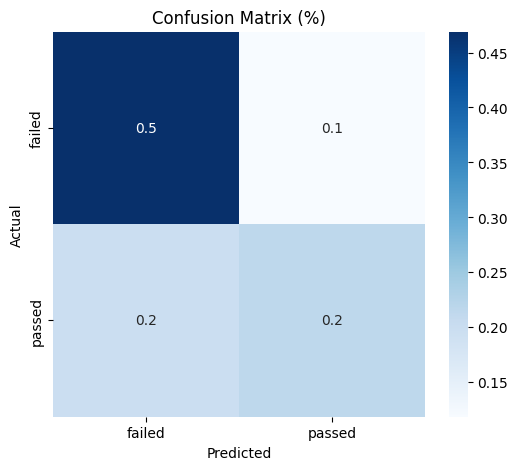

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       104
           1       0.64      0.52      0.58        73

    accuracy                           0.68       177
   macro avg       0.67      0.66      0.66       177
weighted avg       0.68      0.68      0.68       177

Mean CV accuracy across folds: 0.6849673202614379 ± 0.08695758505461428

With PCA:
Best k: 17


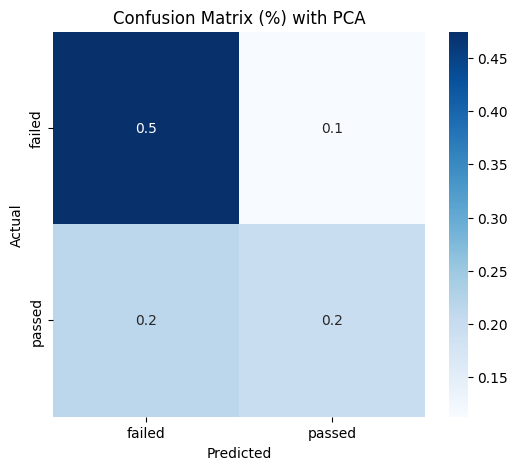

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       104
           1       0.64      0.48      0.55        73

    accuracy                           0.67       177
   macro avg       0.66      0.64      0.65       177
weighted avg       0.67      0.67      0.66       177

Mean CV accuracy across folds: 0.6712418300653595 ± 0.08657602294605769



In [ ]:
# KNN
def my_knn(df1):
  k_vals = [9,11,13,15,17,19,21] # Found this range to be the best via experimentation?
  grid_model = skm.GridSearchCV(
      KNeighborsClassifier(),
      {'n_neighbors':k_vals},
      refit=True,
      cv=kfold,
      scoring='accuracy'
  )

  grid_model.fit(df1.drop(['passed'], axis=1), df1['passed'])
  best_k = grid_model.best_params_['n_neighbors']
  print(f"Best k: {best_k}")

  knn = KNeighborsClassifier(n_neighbors=best_k)
  y_pred_cv = skm.cross_val_predict(knn, df1.drop(['passed'], axis=1), df1['passed'], cv=kfold)

  cm = confusion_matrix(df1['passed'], y_pred_cv, normalize='all')
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
              xticklabels=['failed', 'passed'], yticklabels=['failed', 'passed'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  if(df1 is df1_pca):
    plt.title("Confusion Matrix (%) with PCA")
  else:
    plt.title("Confusion Matrix (%)")
  plt.show()

  print(classification_report(df1['passed'], y_pred_cv))
  # accuracy = accuracy_score(df1['passed'], y_pred_cv)
  # print(f"Overall CV accuracy: {accuracy}\n")
  scores = skm.cross_val_score(knn, df1.drop(['passed'], axis=1), df1['passed'], cv=kfold, scoring='accuracy')

  print(f"Mean CV accuracy across folds: {scores.mean()} ± {scores.std()}\n")

print("Without PCA:")
my_knn(df1)
print("With PCA:")
my_knn(df1_pca)

Without PCA:
Best depth: 3


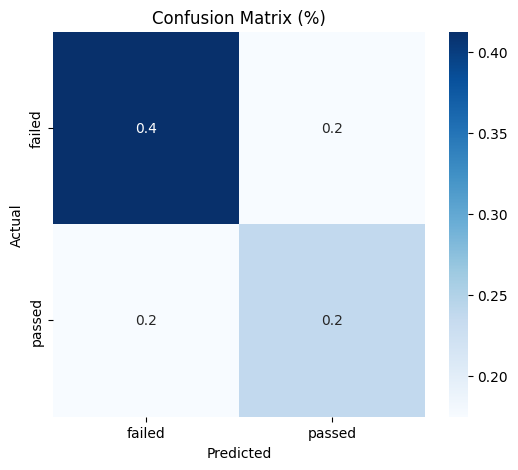

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       104
           1       0.58      0.58      0.58        73

    accuracy                           0.65       177
   macro avg       0.64      0.64      0.64       177
weighted avg       0.65      0.65      0.65       177

Mean CV accuracy across folds: 0.6506535947712418 ± 0.0858979950140806

With PCA:
Best depth: 3


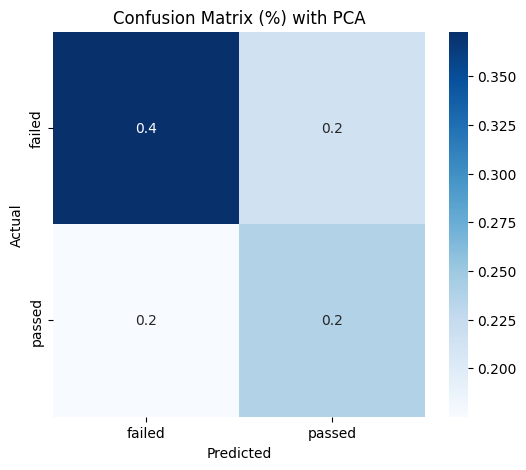

              precision    recall  f1-score   support

           0       0.68      0.63      0.66       104
           1       0.53      0.58      0.55        73

    accuracy                           0.61       177
   macro avg       0.60      0.60      0.60       177
weighted avg       0.62      0.61      0.61       177

Mean CV accuracy across folds: 0.6098039215686275 ± 0.10503575040962052



In [ ]:
# Random Forest
def my_rf(df1):
  n_features = df1.drop(['passed'], axis=1).shape[1]
  depth_vals = [1, 2, 3, 4, 5]
  rf = RandomForestClassifier(
    n_estimators=100,
    # max_depth=10,
    max_features=int(np.sqrt(n_features)),  # features considered per split
    class_weight='balanced',
    random_state=0
  )
  grid_model = skm.GridSearchCV(
    estimator=rf,
    param_grid={'max_depth': depth_vals},
    scoring='accuracy',
    cv=10,
    refit=True
  )

  grid_model.fit(df1.drop(['passed'], axis=1), df1['passed'])
  best_depth = grid_model.best_params_['max_depth']
  print(f"Best depth: {best_depth}")
  best_model = grid_model.best_estimator_

  y_pred_cv = skm.cross_val_predict(best_model, df1.drop(['passed'], axis=1), df1['passed'], cv=kfold)

  cm = confusion_matrix(df1['passed'], y_pred_cv, normalize='all')
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
              xticklabels=['failed', 'passed'], yticklabels=['failed', 'passed'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  if(df1 is df1_pca):
    plt.title("Confusion Matrix (%) with PCA")
  else:
    plt.title("Confusion Matrix (%)")
  plt.show()

  print(classification_report(df1['passed'], y_pred_cv))
  # accuracy = accuracy_score(df1['passed'], y_pred_cv)
  # print(f"Overall CV accuracy: {accuracy}\n")
  scores = skm.cross_val_score(best_model, df1.drop(['passed'], axis=1), df1['passed'], cv=kfold, scoring='accuracy')

  print(f"Mean CV accuracy across folds: {scores.mean()} ± {scores.std()}\n")

print("Without PCA:")
my_rf(df1)
print("With PCA:")
my_rf(df1_pca)

Without PCA:
Best C: 1


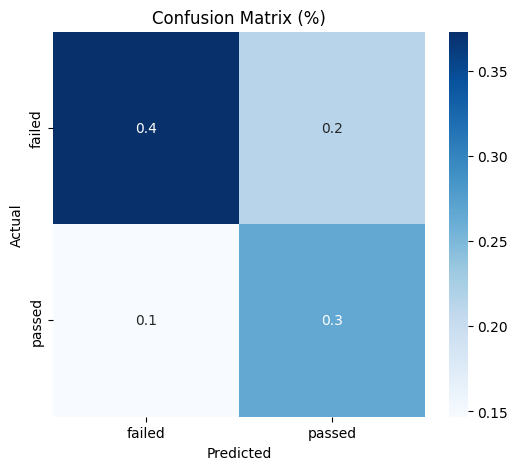

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       104
           1       0.55      0.64      0.59        73

    accuracy                           0.64       177
   macro avg       0.64      0.64      0.63       177
weighted avg       0.65      0.64      0.64       177

Mean CV accuracy across folds: 0.6323529411764707 ± 0.13638261569908294

With PCA:
Best C: 1


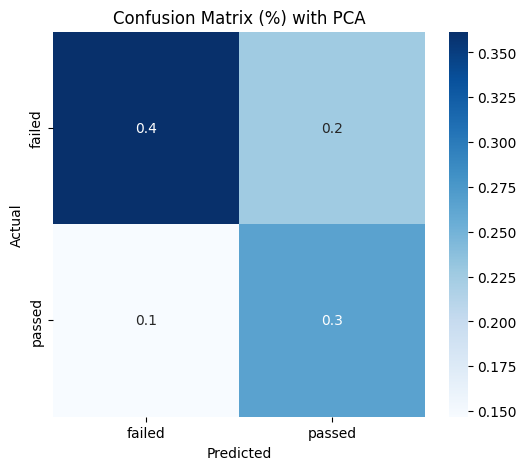

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       104
           1       0.54      0.64      0.59        73

    accuracy                           0.63       177
   macro avg       0.63      0.63      0.62       177
weighted avg       0.64      0.63      0.63       177

Mean CV accuracy across folds: 0.6333333333333334 ± 0.09804792989594341



In [ ]:
# Log Reg
def my_logit(df1):
  C_vals = [0.01, 0.1, 1, 10]
  logit = LogisticRegression(
    class_weight='balanced',
    penalty='l1', # l1 is lasso
    solver='liblinear',

    random_state=0
  )
  grid_model = skm.GridSearchCV(
    estimator=logit,
    param_grid={'C': C_vals},
    scoring='accuracy',
    cv=10,
    refit=True
  )

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(df1.drop('passed', axis=1))

  grid_model.fit(X_scaled, df1['passed'])
  best_C = grid_model.best_params_['C']
  print(f"Best C: {best_C}")
  best_model = grid_model.best_estimator_


  y_pred_cv = skm.cross_val_predict(best_model, X_scaled, df1['passed'], cv=kfold)

  cm = confusion_matrix(df1['passed'], y_pred_cv, normalize='all')
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
              xticklabels=['failed', 'passed'], yticklabels=['failed', 'passed'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  if(df1 is df1_pca):
    plt.title("Confusion Matrix (%) with PCA")
  else:
    plt.title("Confusion Matrix (%)")
  plt.show()

  print(classification_report(df1['passed'], y_pred_cv))
  # accuracy = accuracy_score(df1['passed'], y_pred_cv)
  # print(f"Overall CV accuracy: {accuracy}\n")
  scores = skm.cross_val_score(best_model, df1.drop(['passed'], axis=1), df1['passed'], cv=kfold, scoring='accuracy')

  print(f"Mean CV accuracy across folds: {scores.mean()} ± {scores.std()}\n")

print("Without PCA:")
my_logit(df1)
print("With PCA:")
my_logit(df1_pca)

In [ ]:
# Part 2: predict letter grade of observation
def bin_grades(df):
  df2 = df.copy(deep=True)
  # 'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0
  df2['grade'] = df['Total Score'].apply(lambda x: 4 if x >= 65*0.9 else
                                                   3 if x >= 65*0.8 else
                                                   2 if x >= 65*0.7 else
                                                   1 if x >= 65*0.6 else
                                                   0
                                         )
  df2.drop(['Total Score'], inplace=True, axis=1)

  return df2

df2 = bin_grades(df)
df2_pca = bin_grades(df_pca)

kfold = skm.KFold(10, random_state=0, shuffle=True)

df2_pca.head()
df2['grade'].value_counts()/df2.shape[0]

,count
grade,
0,0.327684
1,0.259887
2,0.225989
3,0.163842
4,0.022599


Without PCA:
Best k: 17


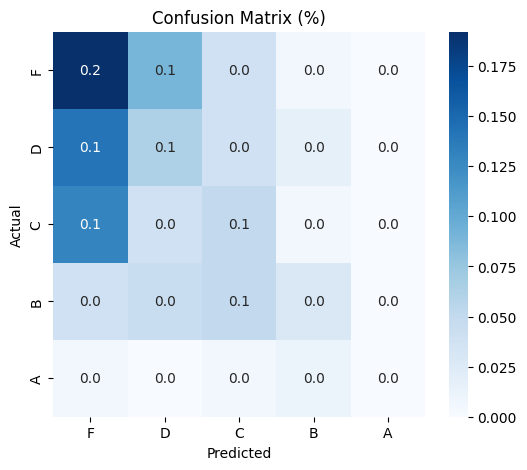

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.38      0.59      0.46        58
           1       0.26      0.24      0.25        46
           2       0.27      0.23      0.25        40
           3       0.42      0.17      0.24        29
           4       0.00      0.00      0.00         4

    accuracy                           0.33       177
   macro avg       0.27      0.24      0.24       177
weighted avg       0.32      0.33      0.31       177

Mean CV accuracy across folds: 0.33333333333333337 ± 0.0718954248366013

With PCA:
Best k: 13


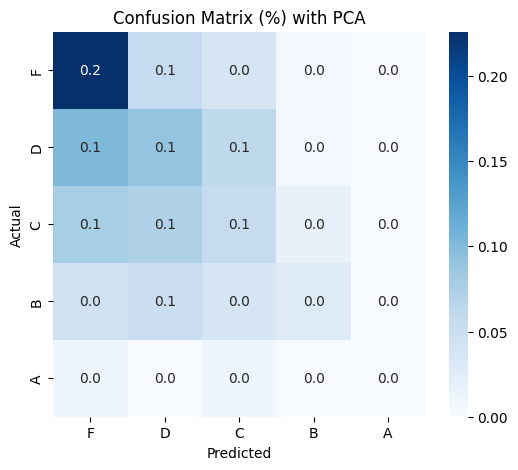

              precision    recall  f1-score   support

           0       0.49      0.69      0.57        58
           1       0.33      0.35      0.34        46
           2       0.27      0.25      0.26        40
           3       0.50      0.17      0.26        29
           4       0.00      0.00      0.00         4

    accuracy                           0.40       177
   macro avg       0.32      0.29      0.29       177
weighted avg       0.39      0.40      0.38       177

Mean CV accuracy across folds: 0.40098039215686276 ± 0.12268663297490114



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def my_knn(df1):
  k_vals = [1,3,5,7,9,11,13,15,17,19,21] # Found this range to be the best via experimentation?
  grid_model = skm.GridSearchCV(
      KNeighborsClassifier(),
      {'n_neighbors':k_vals},
      refit=True,
      cv=kfold,
      scoring='accuracy'
  )

  grid_model.fit(df1.drop(['grade'], axis=1), df1['grade'])
  best_k = grid_model.best_params_['n_neighbors']
  print(f"Best k: {best_k}")

  knn = KNeighborsClassifier(n_neighbors=best_k)
  y_pred_cv = skm.cross_val_predict(knn, df1.drop(['grade'], axis=1), df1['grade'], cv=kfold)

  cm = confusion_matrix(df1['grade'], y_pred_cv, normalize='all')
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
              xticklabels=['F', 'D', 'C', 'B', 'A'], yticklabels=['F', 'D', 'C', 'B', 'A'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  if(df1 is df2_pca):
    plt.title("Confusion Matrix (%) with PCA")
  else:
    plt.title("Confusion Matrix (%)")
  plt.show()

  print(classification_report(df1['grade'], y_pred_cv))
  # accuracy = accuracy_score(df1['passed'], y_pred_cv)
  # print(f"Overall CV accuracy: {accuracy}\n")
  scores = skm.cross_val_score(knn, df1.drop(['grade'], axis=1), df1['grade'], cv=kfold, scoring='accuracy')

  print(f"Mean CV accuracy across folds: {scores.mean()} ± {scores.std()}\n")

print("Without PCA:")
my_knn(df2)
print("With PCA:")
my_knn(df2_pca)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Without PCA:
Best depth: 3


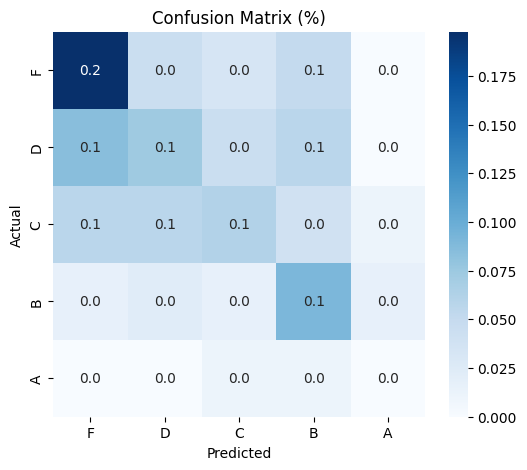

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        58
           1       0.37      0.28      0.32        46
           2       0.37      0.28      0.31        40
           3       0.36      0.55      0.44        29
           4       0.00      0.00      0.00         4

    accuracy                           0.42       177
   macro avg       0.33      0.34      0.33       177
weighted avg       0.42      0.42      0.42       177

Mean CV accuracy across folds: 0.42450980392156856 ± 0.07161934514739808

With PCA:


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Best depth: 5


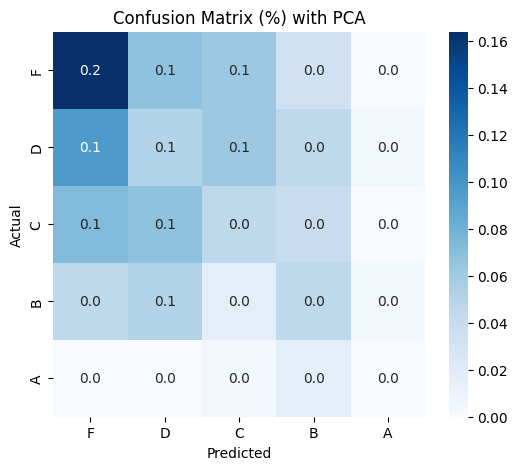

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        58
           1       0.21      0.20      0.20        46
           2       0.24      0.20      0.22        40
           3       0.25      0.28      0.26        29
           4       0.00      0.00      0.00         4

    accuracy                           0.31       177
   macro avg       0.23      0.23      0.23       177
weighted avg       0.29      0.31      0.30       177

Mean CV accuracy across folds: 0.3055555555555555 ± 0.08470610929526609



In [ ]:
# Random Forest
def my_rf(df1):
  n_features = df1.drop(['grade'], axis=1).shape[1]
  depth_vals = [1, 2, 3, 4, 5]
  rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    max_features=int(np.sqrt(n_features)),  # features considered per split
    class_weight='balanced',
    random_state=0
  )
  grid_model = skm.GridSearchCV(
    estimator=rf,
    param_grid={'max_depth': depth_vals},
    scoring='accuracy',
    cv=10,
    refit=True
  )

  grid_model.fit(df1.drop(['grade'], axis=1), df1['grade'])
  best_depth = grid_model.best_params_['max_depth']
  print(f"Best depth: {best_depth}")
  best_model = grid_model.best_estimator_

  y_pred_cv = skm.cross_val_predict(best_model, df1.drop(['grade'], axis=1), df1['grade'], cv=kfold)

  cm = confusion_matrix(df1['grade'], y_pred_cv, normalize='all')
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
              xticklabels=['F', 'D', 'C', 'B', 'A'], yticklabels=['F', 'D', 'C', 'B', 'A'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  if(df1 is df2_pca):
    plt.title("Confusion Matrix (%) with PCA")
  else:
    plt.title("Confusion Matrix (%)")
  plt.show()

  print(classification_report(df1['grade'], y_pred_cv))
  # accuracy = accuracy_score(df1['passed'], y_pred_cv)
  # print(f"Overall CV accuracy: {accuracy}\n")
  scores = skm.cross_val_score(best_model, df1.drop(['grade'], axis=1), df1['grade'], cv=kfold, scoring='accuracy')

  print(f"Mean CV accuracy across folds: {scores.mean()} ± {scores.std()}\n")

print("Without PCA:")
my_rf(df2)
print("With PCA:")
my_rf(df2_pca)

Epoch:1, loss: 1.943
Epoch:11, loss: 1.415
Epoch:21, loss: 1.332
Epoch:31, loss: 1.228
Epoch:41, loss: 1.138
Finished Training
Test Accuracy: 0.3611111111111111


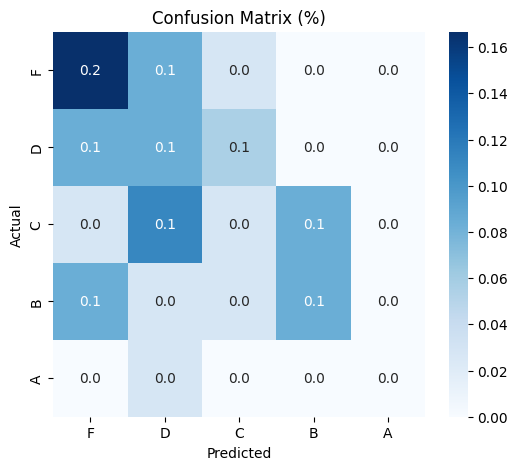

In [ ]:
# DNN code is courtesy of Deep Ray

X_raw = df2.drop('grade', axis=1).values
y_raw = df2['grade'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Convert to PyTorch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw, dtype=torch.long)

# Wrap in a PyTorch dataset
dataset = TensorDataset(X, y)

total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Random split
generator = torch.Generator().manual_seed(0)
trainset, testset = random_split(dataset, [train_size, test_size], generator=generator)

batch_size  = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



fold_accuracies = []

class MLP(nn.Module):
    def __init__(self, input_dim=1, out_dim=1, hwidths=[5,5,5],dropout_param=0.5):
        super(MLP, self).__init__()

        n_hidden = len(hwidths)

        # Want to ensure there is at least one hidden layer
        assert n_hidden > 1

        self.depth= n_hidden+1

        # Create list of layers and include the first hidden layer
        MLP_list = [nn.Linear(input_dim, hwidths[0]),nn.ReLU(),nn.Dropout(dropout_param)]

        # Remaining hidden layers
        for i in range(self.depth - 2):
            MLP_list += [nn.Linear(hwidths[i], hwidths[i+1]),nn.ReLU(),nn.Dropout(dropout_param)]

        # Output layer
        # NOTE: Won't apply softmax explicitly since the loss function automatically
        # applies is in Pytorch
        MLP_list += [nn.Linear(hwidths[-1], out_dim)]

        # Adding list of layers as modules
        self.model = nn.ModuleList(MLP_list)

    # Defining forward mode of MLP model
    def forward(self, x):
      for i, layer in enumerate(self.model):
          x = layer(x)
      return x

net = MLP( input_dim=10,
           out_dim = 6,
           hwidths=[32,16],
           dropout_param=0.3)

criterion = nn.CrossEntropyLoss() # Automatically applied softmax
optimizer = optim.Adam(net.parameters())
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    if epoch % 10 == 0:
      print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

net.eval()  # set to evaluation mode (disables dropout)
y_true = []
y_pred = []

with torch.no_grad():  # no gradient tracking during evaluation
    for inputs, labels in testloader:
        outputs = net(inputs)

        # For multi-class classification (CrossEntropyLoss)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc}")

cm = confusion_matrix(y_true, y_pred, normalize='all')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
            xticklabels=['F', 'D', 'C', 'B', 'A'], yticklabels=['F', 'D', 'C', 'B', 'A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()

Fold 1/10
Epoch 1, Loss: 1.791
Epoch 11, Loss: 1.403
Epoch 21, Loss: 1.285
Epoch 31, Loss: 1.228
Epoch 41, Loss: 1.204
Fold 1 Accuracy: 0.3333333333333333

Fold 2/10
Epoch 1, Loss: 1.820
Epoch 11, Loss: 1.479
Epoch 21, Loss: 1.372
Epoch 31, Loss: 1.275
Epoch 41, Loss: 1.249
Fold 2 Accuracy: 0.5555555555555556

Fold 3/10
Epoch 1, Loss: 1.837
Epoch 11, Loss: 1.398
Epoch 21, Loss: 1.257
Epoch 31, Loss: 1.251
Epoch 41, Loss: 1.218
Fold 3 Accuracy: 0.5

Fold 4/10
Epoch 1, Loss: 1.758
Epoch 11, Loss: 1.426
Epoch 21, Loss: 1.278
Epoch 31, Loss: 1.256
Epoch 41, Loss: 1.200
Fold 4 Accuracy: 0.3333333333333333

Fold 5/10
Epoch 1, Loss: 1.753
Epoch 11, Loss: 1.410
Epoch 21, Loss: 1.299
Epoch 31, Loss: 1.264
Epoch 41, Loss: 1.205
Fold 5 Accuracy: 0.6666666666666666

Fold 6/10
Epoch 1, Loss: 1.834
Epoch 11, Loss: 1.423
Epoch 21, Loss: 1.294
Epoch 31, Loss: 1.253
Epoch 41, Loss: 1.224
Fold 6 Accuracy: 0.3888888888888889

Fold 7/10
Epoch 1, Loss: 1.806
Epoch 11, Loss: 1.361
Epoch 21, Loss: 1.333
Epoc

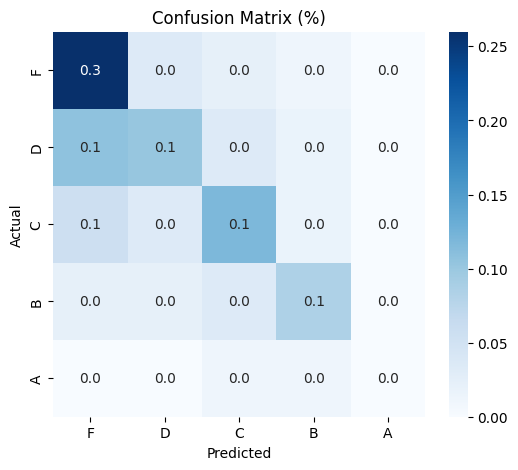

In [ ]:
# DNN with CV
# Features and labels
X_raw = df2.drop('grade', axis=1).values
y_raw = df2['grade'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Convert to PyTorch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw, dtype=torch.long)

# Wrap in a PyTorch dataset
dataset = TensorDataset(X, y)

# Define k-fold CV
k = 10
kf = skm.KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{k}")

    # Create train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    trainloader = DataLoader(train_subset, batch_size=8, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=8, shuffle=False)

    # Define network (re-initialize each fold)
    net = MLP(input_dim=10, out_dim=6, hwidths=[32,16], dropout_param=0.3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Train
    for epoch in range(50):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")

    # Evaluate
    net.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_true, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc}\n")

# CV results
fold_accuracies = np.array(fold_accuracies)
print(f"Mean CV accuracy across folds: {fold_accuracies.mean()} ± {fold_accuracies.std()}")


# Optional: combine all folds for confusion matrix
y_true_all, y_pred_all = [], []
for train_idx, val_idx in kf.split(dataset):
    val_subset = Subset(dataset, val_idx)
    valloader = DataLoader(val_subset, batch_size=8, shuffle=False)
    net.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_all.extend(labels.numpy())
            y_pred_all.extend(predicted.numpy())

cm = confusion_matrix(y_true_all, y_pred_all, normalize='all')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=['F','D','C','B','A'], yticklabels=['F','D','C','B','A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")

plt.show()

Fold 1/10
Epoch 1, Loss: 1.793
Epoch 11, Loss: 1.449
Epoch 21, Loss: 1.308
Epoch 31, Loss: 1.212
Epoch 41, Loss: 1.179
Fold 1 Accuracy: 0.2222222222222222

Fold 2/10
Epoch 1, Loss: 1.765
Epoch 11, Loss: 1.452
Epoch 21, Loss: 1.356
Epoch 31, Loss: 1.304
Epoch 41, Loss: 1.212
Fold 2 Accuracy: 0.5555555555555556

Fold 3/10
Epoch 1, Loss: 1.810
Epoch 11, Loss: 1.448
Epoch 21, Loss: 1.303
Epoch 31, Loss: 1.242
Epoch 41, Loss: 1.215
Fold 3 Accuracy: 0.4444444444444444

Fold 4/10
Epoch 1, Loss: 1.746
Epoch 11, Loss: 1.445
Epoch 21, Loss: 1.312
Epoch 31, Loss: 1.250
Epoch 41, Loss: 1.174
Fold 4 Accuracy: 0.3333333333333333

Fold 5/10
Epoch 1, Loss: 1.748
Epoch 11, Loss: 1.417
Epoch 21, Loss: 1.320
Epoch 31, Loss: 1.276
Epoch 41, Loss: 1.238
Fold 5 Accuracy: 0.5555555555555556

Fold 6/10
Epoch 1, Loss: 1.849
Epoch 11, Loss: 1.428
Epoch 21, Loss: 1.277
Epoch 31, Loss: 1.224
Epoch 41, Loss: 1.180
Fold 6 Accuracy: 0.2777777777777778

Fold 7/10
Epoch 1, Loss: 1.888
Epoch 11, Loss: 1.400
Epoch 21, L

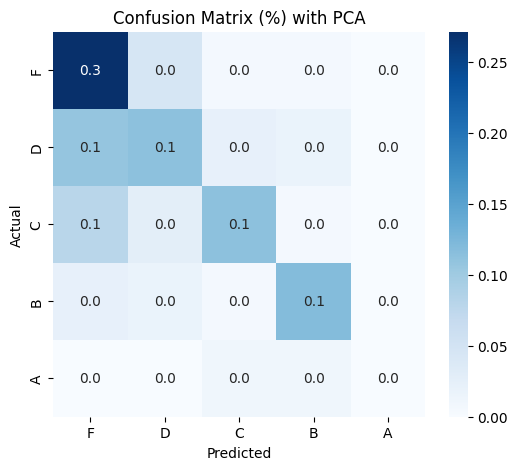

In [ ]:
# DNN with CV & PCA
# Features and labels
X_raw = df2_pca.drop('grade', axis=1).values
y_raw = df2_pca['grade'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Convert to PyTorch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw, dtype=torch.long)

# Wrap in a PyTorch dataset
dataset = TensorDataset(X, y)

# Define k-fold CV
k = 10
kf = skm.KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{k}")

    # Create train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    trainloader = DataLoader(train_subset, batch_size=8, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=8, shuffle=False)

    # Define network (re-initialize each fold)
    net = MLP(input_dim=9, out_dim=6, hwidths=[32,16], dropout_param=0.3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Train
    for epoch in range(50):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")

    # Evaluate
    net.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_true, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc}\n")

# CV results
fold_accuracies = np.array(fold_accuracies)
print(f"Mean CV accuracy across folds: {fold_accuracies.mean()} ± {fold_accuracies.std()}")


# Optional: combine all folds for confusion matrix
y_true_all, y_pred_all = [], []
for train_idx, val_idx in kf.split(dataset):
    val_subset = Subset(dataset, val_idx)
    valloader = DataLoader(val_subset, batch_size=8, shuffle=False)
    net.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_all.extend(labels.numpy())
            y_pred_all.extend(predicted.numpy())

cm = confusion_matrix(y_true_all, y_pred_all, normalize='all')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=['F','D','C','B','A'], yticklabels=['F','D','C','B','A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%) with PCA")

plt.show()

In [ ]:
# Part 3: regression analysis
def my_reg(df2):
  X_raw = df2.drop('Total Score', axis=1)

  # Standardize features
  scaler = StandardScaler()
  X = scaler.fit_transform(X_raw)
  y = df2['Total Score']

  X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=42)

  # Define a range of alpha values to test
  alphas = np.logspace(-4, 1, 50)  # 50 values from 0.0001 to 10

  # Initialize LassoCV
  lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=0)

  # Fit model
  lasso_cv.fit(X_train, y_train)

  # Best alpha
  print("Best alpha:", lasso_cv.alpha_)

  # Predictions
  y_pred = lasso_cv.predict(X_test)
  # y_pred = list(map(round, y_pred))
  # print(y_pred)

  # Evaluate
  r2 = r2_score(y_test, y_pred)
  print(f"Test R^2: {r2}")
  # accuracy = accuracy_score(y_test, y_pred)Z

  # Coefficients
  print("Intercept:", lasso_cv.intercept_)
  print("Coefficients:")
  for feature, coef in zip(X_raw.columns, lasso_cv.coef_):
      print(f"{feature}: {coef}")

print("Without PCA:")
my_reg(df)

Without PCA:
Best alpha: 0.47148663634573945
Test R^2: 0.27830243119866993
Intercept: 42.56171220512349
Coefficients:
attendance: -0.0
prior_exp: 0.5713854591016243
afternoon_section: -1.0591517758727693
study_len: -0.0
year: -0.0
readings: 1.4608624697314037
scrolling_len: 0.0
sleep_len: 2.2356863305802612
left_early: 0.0
thought_grade: 3.728355892449966


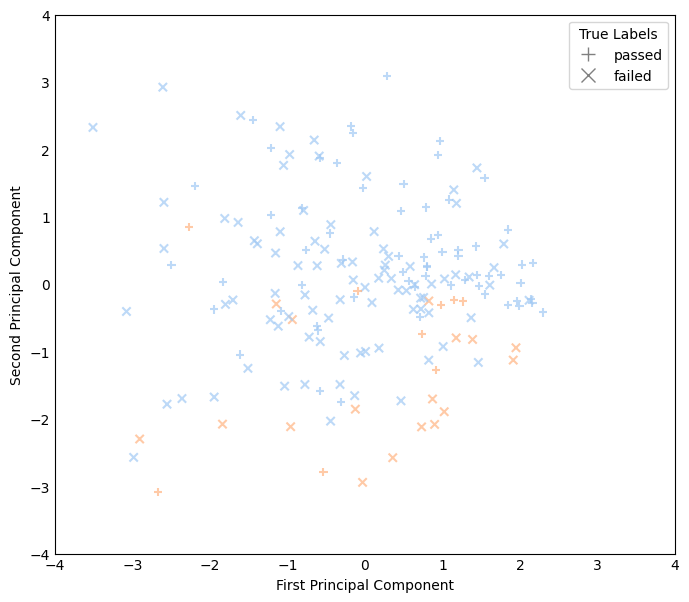

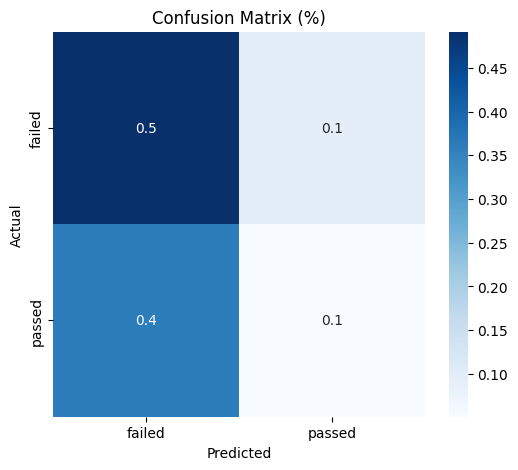


Cluster Accuracy: 0.542


In [ ]:
# kmeans into pass/fail
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df1.drop(['passed'], axis=1))
clusters = kmeans.labels_

df_pca = pca.fit_transform(scaler.fit_transform(df1.drop(columns=['passed'])))

plt.figure(figsize=(8, 7))
# plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)
colors = sns.color_palette("pastel", n_colors=2)
for passed_value, marker in zip([0, 1], ['x', '+']):
    mask = df1['passed'] == passed_value
    plt.scatter(
        df_pca[mask, 0],
        df_pca[mask, 1],
        c=[colors[i] for i in kmeans.labels_[mask]],
        marker=marker,
        alpha=0.7,
        label=f"passed={passed_value}"
    )

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
legend_elements = [
    plt.Line2D([0], [0], marker='+', color='w',
               markeredgecolor='gray', markersize=10, label='passed'),
    plt.Line2D([0], [0], marker='x', color='w',
               markeredgecolor='gray', markersize=10, label='failed')
]
plt.legend(handles=legend_elements, title="True Labels", loc="upper right")
plt.show()

# True labels (0 = fail, 1 = pass)
y_true = df1['passed'].values

# Predicted cluster labels
y_pred = kmeans.labels_
# KMeans labels are arbitrary (e.g. 0 and 1 might be swapped)
# So we test both possible mappings:
acc1 = accuracy_score(y_true, y_pred)
acc2 = accuracy_score(y_true, 1 - y_pred)

# Pick the best mapping
if acc2 > acc1:
    y_pred = 1 - y_pred  # flip cluster labels

# Compute confusion matrix and accuracy
# print("Confusion Matrix:\n", pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))
cm = confusion_matrix(y_true, y_pred, normalize='all')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
            xticklabels=['failed', 'passed'], yticklabels=['failed', 'passed'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()
acc = accuracy_score(y_true, y_pred)
print(f"\nCluster Accuracy: {acc:.3f}")


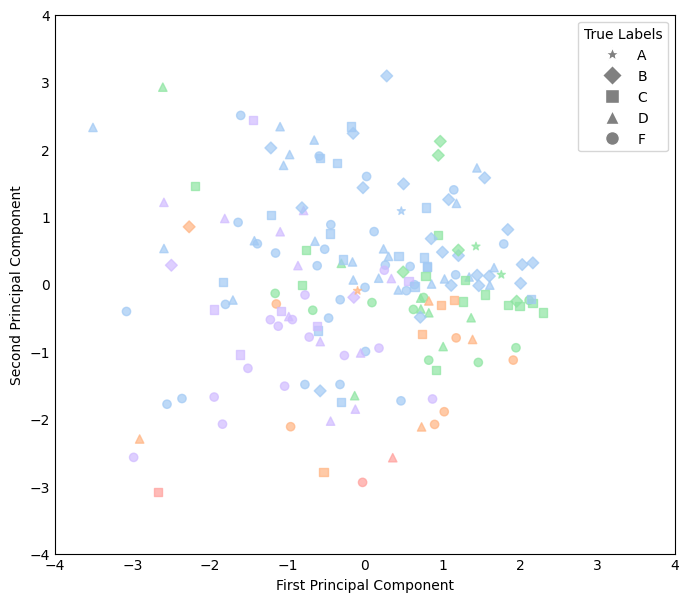

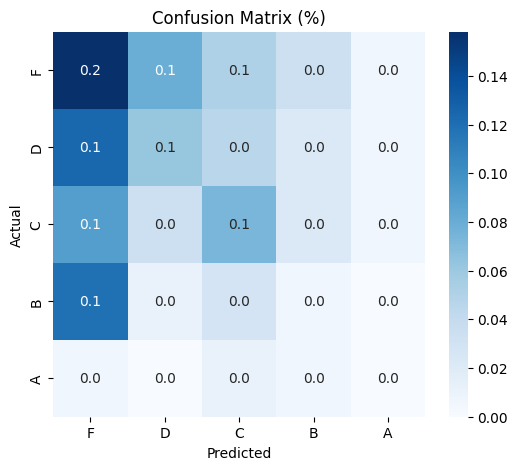


Cluster Accuracy: 0.254


In [ ]:
# kmeans into grade bin
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df2.drop(['grade'], axis=1))
clusters = kmeans.labels_

df_pca = pca.fit_transform(scaler.fit_transform(df2.drop(columns=['grade'])))

plt.figure(figsize=(8, 7))

plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)
colors = sns.color_palette("pastel", n_colors=5)
for passed_value, marker in zip([0, 1, 2, 3, 4], ['o', '^', "s", "D", "*"]):
    mask = df2['grade'] == passed_value
    plt.scatter(
        df_pca[mask, 0],
        df_pca[mask, 1],
        c=[colors[i] for i in kmeans.labels_[mask]],
        marker=marker,
        alpha=0.7,
        label=f"passed={passed_value}"
    )

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=10, label='A'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='gray', markersize=10, label='B'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, label='C'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='D'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='F'),
]
plt.legend(handles=legend_elements, title="True Labels", loc="upper right")
plt.show()

y_true = df2['grade'].values
y_pred = kmeans.labels_
cm = confusion_matrix(y_true, y_pred)
row_ind, col_ind = linear_sum_assignment(-cm)

# Create mapping dict: cluster -> grade
mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Apply mapping
y_pred_mapped = np.array([mapping[c] for c in y_pred])

# Compute confusion matrix and accuracy
# print("Confusion Matrix:\n", pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))
cm = confusion_matrix(y_true, y_pred_mapped, normalize='all')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=True,
            xticklabels=['F','D','C','B','A'], yticklabels=['F','D','C','B','A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()
acc = accuracy_score(y_true, y_pred)
print(f"\nCluster Accuracy: {acc:.3f}")
